In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import feature_selection
import matplotlib.pyplot as plt
import xgboost
import ast
import operator
import math
%matplotlib inline

In [2]:
listings_df = pd.read_csv('nyc_listings.csv')
listings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36923 entries, 0 to 36922
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            36923 non-null  int64  
 1   listing_url                                   36923 non-null  object 
 2   scrape_id                                     36923 non-null  float64
 3   last_scraped                                  36923 non-null  object 
 4   name                                          36910 non-null  object 
 5   description                                   35710 non-null  object 
 6   neighborhood_overview                         22510 non-null  object 
 7   picture_url                                   36923 non-null  object 
 8   host_id                                       36923 non-null  int64  
 9   host_url                                      36923 non-null 

In [3]:
# Removing dollar sign from price field
listings_df['price'] = listings_df['price'].str.replace("[$, ]", "").astype("float")

<ipython-input-3-81d63ba651f4>:2: FutureWarning: The default value of regex will change from True to False in a future version.
  listings_df['price'] = listings_df['price'].str.replace("[$, ]", "").astype("float")


In [4]:
reviews_df = pd.read_csv('nyc_reviews.csv')

# Convert the date to datetime
reviews_df['date'] = pd.to_datetime(reviews_df['date'], format='%Y-%m-%d')
  
# Filter data between two dates
reviews_df = reviews_df.loc[(reviews_df['date'] >= '2019-01-01')
                     & (reviews_df['date'] < '2021-12-31')]
reviews_df.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
42,2595,366477703,2019-01-02,165354250,Jacob,The apartment met expectations to how it was i...
43,2595,449815873,2019-05-07,168460710,Christopher,10 / 10 would stay again
44,2595,456489109,2019-05-21,119626931,Alex,Place was so cute and comfy! Host was great an...
45,2595,487972917,2019-07-14,60181725,Andrew,I'm glad I stayed here. I liked everything.<br...
46,2595,514642186,2019-08-21,33952280,Laura,"First of all I have to say, that Jennifer is n..."


In [5]:
# Rename id to listing_id for joining tables
listings_df.rename(columns={'id':'listing_id'}, inplace=True)

In [6]:
# Calculating revenue based on reviews
# Idea from Jingles Airbnb Analysis

booking_df = pd.merge(reviews_df, listings_df, on='listing_id')
booking_df['calculated_revenue'] = booking_df['price'] * booking_df['minimum_nights']

In [7]:
revenue_listing_df = booking_df[['listing_id','calculated_revenue']].groupby(['listing_id']).sum()

In [8]:
listings_df = pd.merge(listings_df, revenue_listing_df, on='listing_id', how='left')
listings_df.at[listings_df['calculated_revenue'].isnull(), 'calculated_revenue'] = 0

In [9]:
listings_df[['listing_id','number_of_reviews','minimum_nights','price','bedrooms','beds','calculated_revenue']].sort_values('calculated_revenue',ascending=False).head(5)


,listing_id,number_of_reviews,minimum_nights,price,bedrooms,beds,calculated_revenue
21157,33621795,49,30,9999.0,1.0,1.0,14698530.0
21160,33622378,48,30,9999.0,1.0,1.0,14398560.0
17425,26496505,224,31,1800.0,1.0,1.0,8928000.0
21159,33622308,22,30,9999.0,1.0,2.0,6599340.0
15876,22985168,26,72,10000.0,1.0,1.0,5040000.0


In [10]:
pd.set_option('display.max_rows', None)
listings_df[['listing_id','price']].groupby(['price']).count().sort_values('price', ascending=False)

,listing_id
price,
10000.0,7
9999.0,5
9990.0,1
9000.0,1
7314.0,1
7000.0,1
6500.0,2
6429.0,1
6143.0,1


In [11]:
high_price_df = listings_df[listings_df['price'] >= 7000]

high_price_df[['listing_id', 'listing_url', 'accommodates', 'number_of_reviews', 'price', 'calculated_revenue']]

,listing_id,listing_url,accommodates,number_of_reviews,price,calculated_revenue
3420,4308991,https://www.airbnb.com/rooms/4308991,2,9,9990.0,599400.0
3793,4737930,https://www.airbnb.com/rooms/4737930,4,1,9999.0,0.0
7234,9528920,https://www.airbnb.com/rooms/9528920,2,6,7314.0,0.0
10299,13925864,https://www.airbnb.com/rooms/13925864,4,28,10000.0,0.0
13983,20464496,https://www.airbnb.com/rooms/20464496,2,0,9000.0,0.0
15597,22436899,https://www.airbnb.com/rooms/22436899,4,0,10000.0,0.0
15876,22985168,https://www.airbnb.com/rooms/22985168,2,26,10000.0,5040000.0
18260,28135545,https://www.airbnb.com/rooms/28135545,1,0,7000.0,0.0
20089,31219800,https://www.airbnb.com/rooms/31219800,1,11,10000.0,4400000.0
21157,33621795,https://www.airbnb.com/rooms/33621795,2,49,9999.0,14698530.0


In [12]:
# Filter out price greater than 10000
listings_df = listings_df[listings_df['price'] < 7000]

In [13]:
listings_df[['listing_id','listing_url','number_of_reviews','minimum_nights','price','bedrooms','beds','calculated_revenue']].sort_values('calculated_revenue',ascending=False).head(5)


,listing_id,listing_url,number_of_reviews,minimum_nights,price,bedrooms,beds,calculated_revenue
17425,26496505,https://www.airbnb.com/rooms/26496505,224,31,1800.0,1.0,1.0,8928000.0
14648,21427176,https://www.airbnb.com/rooms/21427176,105,365,159.0,3.0,6.0,3656205.0
22075,35220744,https://www.airbnb.com/rooms/35220744,123,80,305.0,1.0,1.0,3001200.0
7591,9836940,https://www.airbnb.com/rooms/9836940,52,364,175.0,2.0,3.0,2611700.0
3766,4717296,https://www.airbnb.com/rooms/4717296,97,180,250.0,1.0,3.0,2475000.0


In [14]:
listings_df[['listing_id','minimum_nights']].groupby(['minimum_nights']).count().sort_values('minimum_nights', ascending=False)

,listing_id
minimum_nights,
1250,1
1124,1
1000,1
999,1
500,5
480,1
400,2
370,1
366,1


In [15]:
# Filter out min nights greater than 500
listings_df = listings_df[listings_df['minimum_nights'] <= 500]

In [16]:
listings_df.drop(['listing_id'], axis = 1, inplace = True)
listings_df.drop(['host_id'], axis = 1, inplace = True)
listings_df.drop(['listing_url'], axis = 1, inplace = True)
listings_df.drop(['scrape_id'], axis = 1, inplace = True)
listings_df.drop(['last_scraped'], axis = 1, inplace = True)
listings_df.drop(['name'], axis = 1, inplace = True)
listings_df.drop(['description'], axis = 1, inplace = True) # don't have the resources/time/knowledge to extract anything from this
listings_df.drop(['neighborhood_overview'], axis = 1, inplace = True)
listings_df.drop(['picture_url'], axis = 1, inplace = True)
listings_df.drop(['host_url'], axis = 1, inplace = True)
listings_df.drop(['host_name'], axis = 1, inplace = True)
listings_df.drop(['host_since'], axis = 1, inplace = True)
listings_df.drop(['host_location'], axis = 1, inplace = True)
listings_df.drop(['host_about'], axis = 1, inplace = True)
listings_df.drop(['host_response_time'], axis = 1, inplace = True)
listings_df.drop(['host_response_rate'], axis = 1, inplace = True)
listings_df.drop(['host_acceptance_rate'], axis = 1, inplace = True)
listings_df.drop(['host_thumbnail_url'], axis = 1, inplace = True)
listings_df.drop(['host_picture_url'], axis = 1, inplace = True)
listings_df.drop(['host_neighbourhood'], axis = 1, inplace = True)
listings_df.drop(['neighbourhood'], axis = 1, inplace = True)
listings_df.drop(['latitude'], axis = 1, inplace = True)
listings_df.drop(['longitude'], axis = 1, inplace = True)
listings_df.drop(['bathrooms'], axis = 1, inplace = True) # entire column missing
listings_df.drop(['minimum_minimum_nights'], axis = 1, inplace = True)
listings_df.drop(['maximum_minimum_nights'], axis = 1, inplace = True)
listings_df.drop(['minimum_maximum_nights'], axis = 1, inplace = True)
listings_df.drop(['maximum_maximum_nights'], axis = 1, inplace = True)
listings_df.drop(['calendar_updated'], axis = 1, inplace = True)
listings_df.drop(['calendar_last_scraped'], axis = 1, inplace = True)
listings_df.drop(['first_review'], axis = 1, inplace = True)
listings_df.drop(['last_review'], axis = 1, inplace = True)
listings_df.drop(['review_scores_rating'], axis = 1, inplace = True)
listings_df.drop(['review_scores_accuracy'], axis = 1, inplace = True)
listings_df.drop(['review_scores_cleanliness'], axis = 1, inplace = True)
listings_df.drop(['review_scores_checkin'], axis = 1, inplace = True)
listings_df.drop(['review_scores_communication'], axis = 1, inplace = True)
listings_df.drop(['review_scores_location'], axis = 1, inplace = True)
listings_df.drop(['review_scores_value'], axis = 1, inplace = True)
listings_df.drop(['reviews_per_month'], axis = 1, inplace = True)
listings_df.drop(['license'], axis = 1, inplace = True)

# this may be able to be parse in the same way that the amenities column is
listings_df.drop(['host_verifications'], axis = 1, inplace = True)

# find out how korosh is parsing through amenities
listings_df.drop(['amenities'], axis = 1, inplace = True)


In [17]:
listings_df['has_availability'] = listings_df['has_availability'].map({'t' : 1, 'f' : 0})
listings_df['instant_bookable'] = listings_df['instant_bookable'].map({'t' : 1, 'f' : 0})
listings_df['host_is_superhost'] = listings_df['host_is_superhost'].map({'t' : 1, 'f' : 0})

listings_df['host_has_profile_pic'] = listings_df['host_has_profile_pic'].map({'t' : 1, 'f' : 0})
listings_df['host_identity_verified'] = listings_df['host_identity_verified'].map({'t' : 1, 'f' : 0})

listings_df['bathrooms_text'] = pd.Categorical(listings_df['bathrooms_text'])
listings_df['bathrooms_text'] = listings_df['bathrooms_text'].cat.codes

listings_df['neighbourhood_cleansed'] = pd.Categorical(listings_df['neighbourhood_cleansed'])
listings_df['neighbourhood_cleansed'] = listings_df['neighbourhood_cleansed'].cat.codes

listings_df['neighbourhood_group_cleansed'] = pd.Categorical(listings_df['neighbourhood_group_cleansed'])
listings_df['neighbourhood_group_cleansed'] = listings_df['neighbourhood_group_cleansed'].cat.codes

listings_df['property_type'] = pd.Categorical(listings_df['property_type'])
listings_df['property_type'] = listings_df['property_type'].cat.codes

listings_df['room_type'] = pd.Categorical(listings_df['room_type'])
listings_df['room_type'] = listings_df['room_type'].cat.codes

In [18]:
# trying to fill null/na values
# interpolate vs ffill
listings_df['minimum_nights_avg_ntm'].fillna(method = "ffill", inplace = True)
listings_df['maximum_nights_avg_ntm'].fillna(method = "ffill", inplace = True)

# assuming one bed per bedroom to fill in missing stuff in bedrooms column
listings_df['bedrooms'].fillna(listings_df['beds'], inplace=True)

#dropping any other rows with missing values
listings_df.dropna(inplace = True)

<AxesSubplot:>

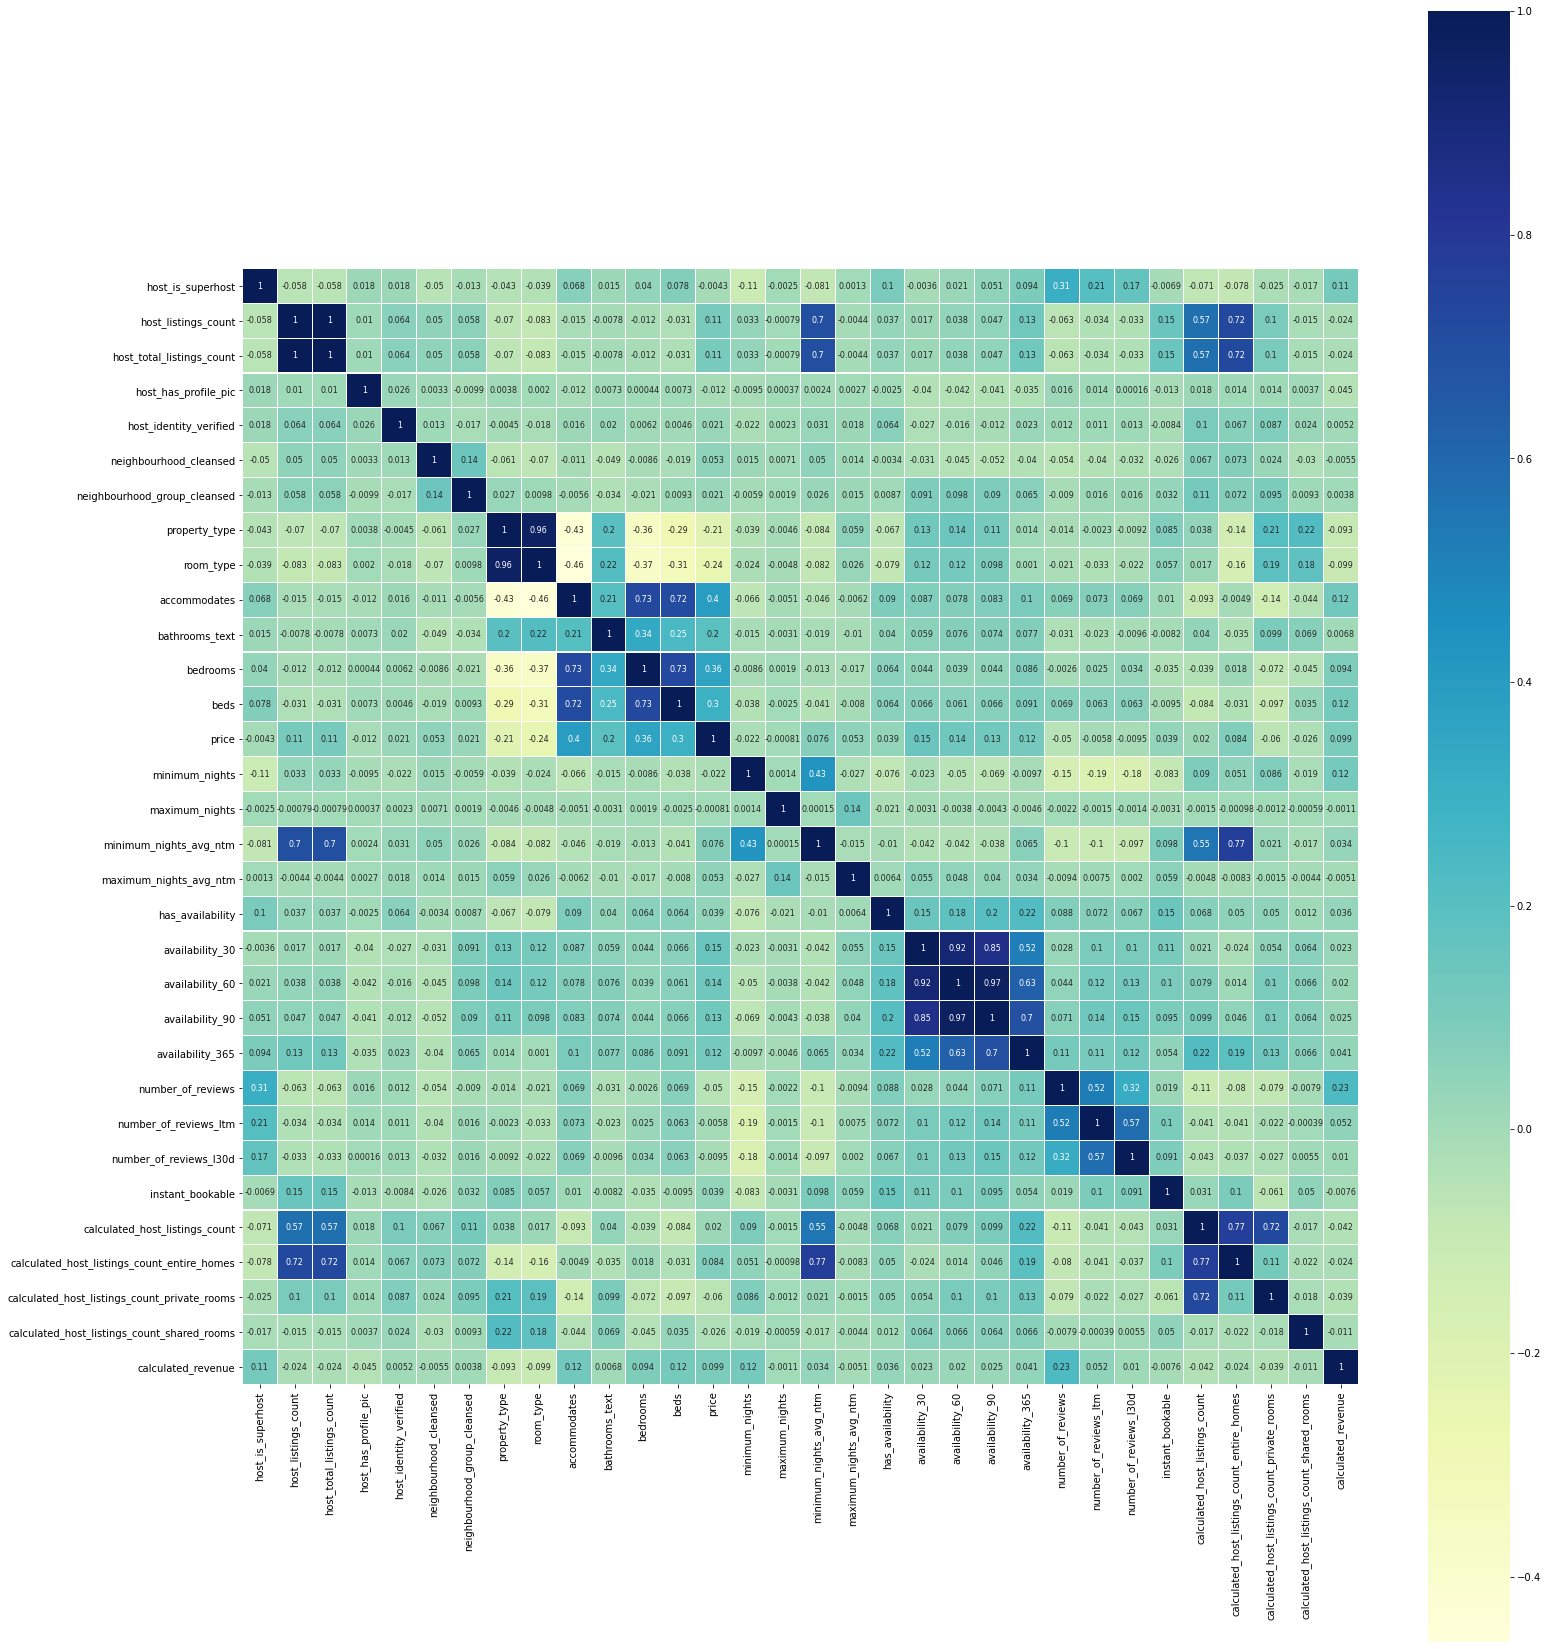

In [19]:
listings_df.corr()
plt.rcParams['figure.figsize'] = [25, 30]
sns.heatmap(listings_df.corr(), vmin=listings_df.corr().values.min(), vmax=1, cmap="YlGnBu", square=True, 
        linewidths=0.1, annot=True, annot_kws={"size":8})  

In [20]:
X = listings_df.iloc[:,:-1]
y = listings_df['calculated_revenue']

In [21]:
# X = feature_selection.SelectKBest(k=10).fit_transform(X,y)
# X.shape

In [22]:
# Split data into 90/10 Train/Test ratio
print("---------- Splitting Data 9:1 Train:Test-----------------")
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.1)

# Specifying the model to use
xg = xgboost.XGBRegressor(eval_metric='rmse')


# Model fitting i.e., creating the model
print("------------------- Fitting Model ----------------------")
xg.fit(X_train, y_train)

---------- Splitting Data 9:1 Train:Test-----------------
------------------- Fitting Model ----------------------


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [23]:
from sklearn.model_selection import cross_val_score

In [24]:
# Make predictions
print("------------------ Making Predictions ------------------")
expected = y_test

xgpredicted = xg.predict(X_test)

------------------ Making Predictions ------------------


In [25]:
# Print performance metrics
print("Model: XGBoost")
print(xg)
print('MAE: ' + str(metrics.mean_absolute_error(y_test, xgpredicted)))
print('RMSE: ' + str(math.sqrt(metrics.mean_squared_error(y_test, xgpredicted))))
print('\n')

Model: XGBoost
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eval_metric='rmse', gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)
MAE: 10113.064985890016
RMSE: 54081.00596901517




In [26]:
xg_reg_mae = cross_val_score(xg, X, y, cv=10,scoring='neg_mean_absolute_error')
xg_reg_rmse = cross_val_score(xg, X, y, cv=10,scoring='neg_root_mean_squared_error')

print("XGBoost Regressor")
print("Mean Absolute Error = {}".format(np.mean(xg_reg_mae)*-1))
print("Root Mean Squared Error = {}".format(np.mean(xg_reg_rmse)*-1))

XGBoost Regressor
Mean Absolute Error = 11289.404929298877
Root Mean Squared Error = 50094.8594729246
